# CNCITY - cassandraConnect


# Importing python packages 

In [1]:
import os
import sys

# Data Analysis
import pandas as pd

# Cassandra
from connection_manager import cassandraConnect
from cassandra.query import dict_factory

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import tqdm as tqdm
from tabulate import tabulate


# Importing the dataset - saved it to a variable called 'df'

In [2]:
PORT = 9042
KEYSPACE = "cncity_server"
TABLE = "all_data"

# Source DB
CONTACT_POINTS = ["39.118.41.24"]
USERNAME = "cnscada"
PW = "cnscada123!@#"

cc = cassandraConnect(CONTACT_POINTS, USERNAME, PW)
cc.session.row_factory = dict_factory

Connected to Cassandra Successfully: ['39.118.41.24'] 9042


In [3]:
use_machine_code = 1
use_day = 20240422
# save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

###################################

query = """
    SELECT *
    FROM {keyspace_name}.{table_name}
    WHERE machine_code = {query_machine_code}
    AND day = {query_day}
""".format(
    keyspace_name = KEYSPACE,
    table_name = TABLE,
    query_machine_code = use_machine_code,
    query_day = use_day
)

query_result = cc.session.execute(query)
###################################

# Pandas DataFrame으로 전환
df = pd.DataFrame(list(query_result)).sort_values(by='time')
# df.to_csv(save_path, index=False)

print(df.shape)
df.head()

(86188, 22)


,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86187,1,20240422,0,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86186,1,20240422,1,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86185,1,20240422,2,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86184,1,20240422,3,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86183,1,20240422,4,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0


# Visualization - plotted each variable

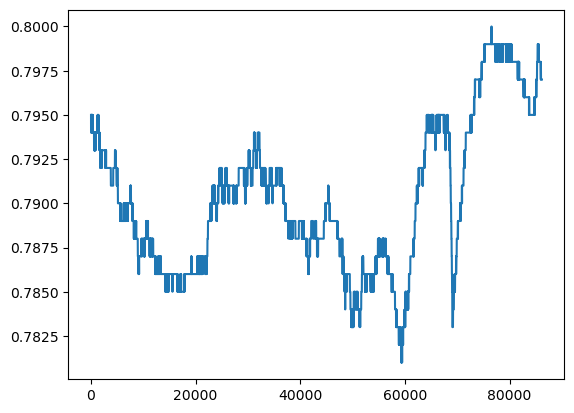

In [11]:
plt.plot(df['pressure_1'])

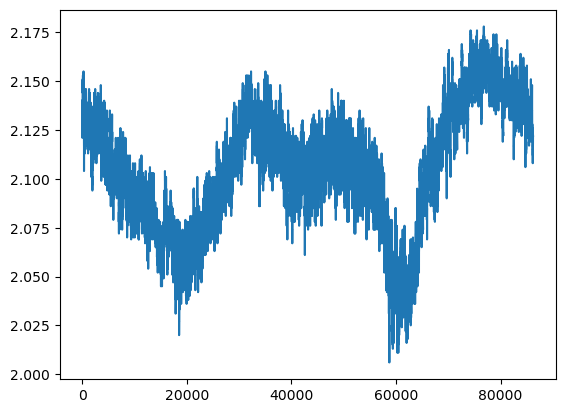

In [15]:
plt.plot(df['pressure_2'])

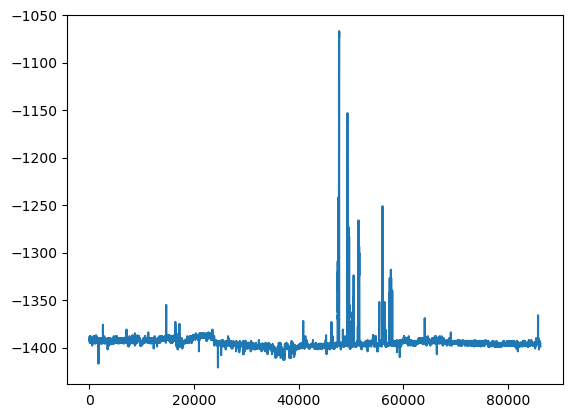

In [62]:
plt.plot(df['electricity_1'])

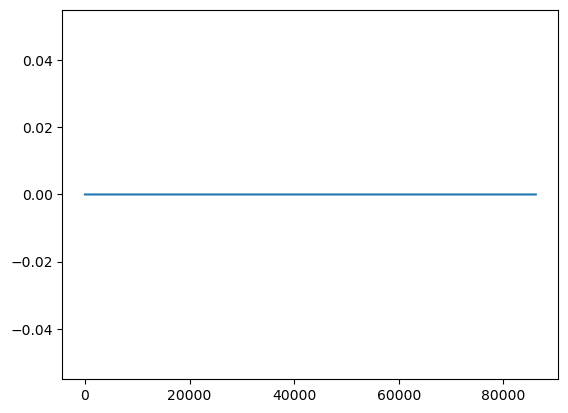

In [61]:
plt.plot(df['electricity_2'])

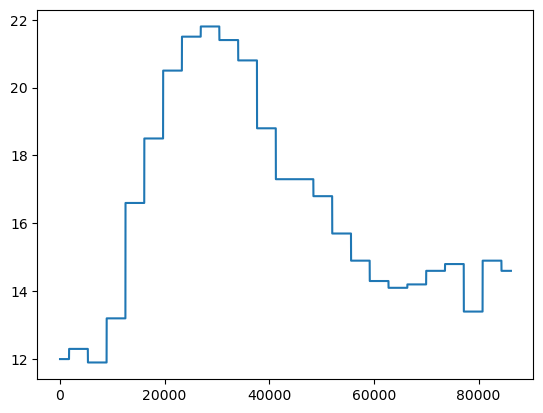

In [14]:
plt.plot(df['outside_temperature'])

# Linear Regression Plots 

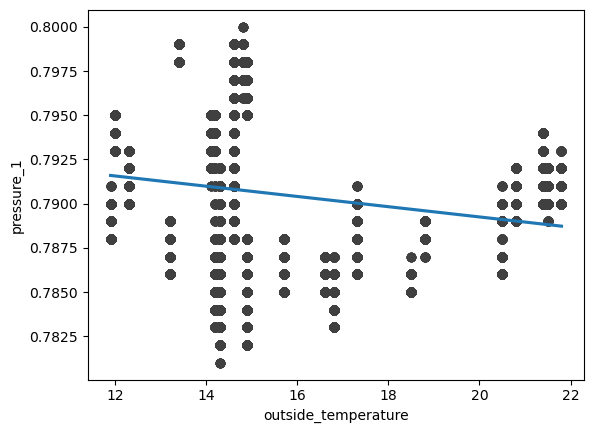

In [179]:
# linear regression with outside_temperature and pressure_1
ax = sns.regplot(x='outside_temperature', y= 'pressure_1', data=df, ci=None, scatter_kws=dict(color='0.25'))

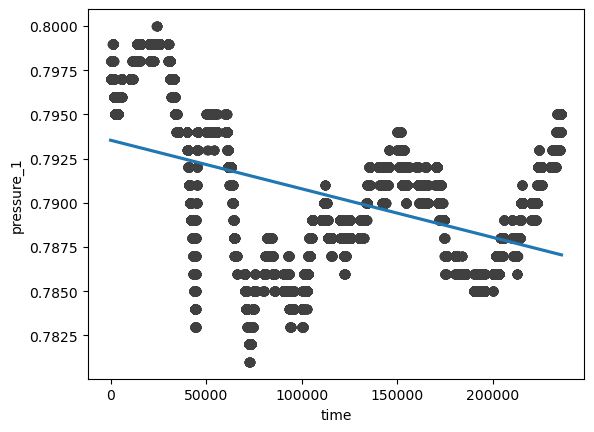

In [180]:
# linear regression with time and pressure_1
ax = sns.regplot(x='time',y='pressure_1',data=df,ci = None, scatter_kws = dict(color = '0.25'))

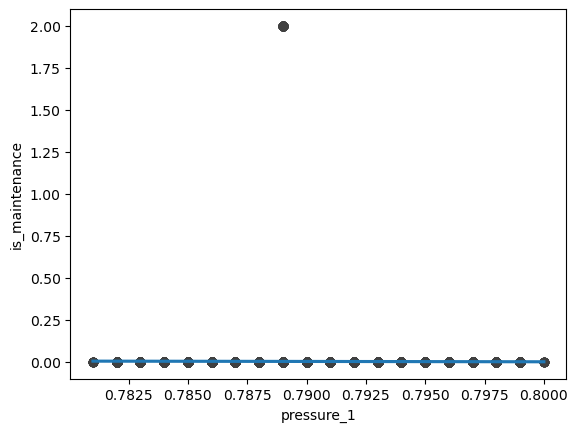

In [181]:
# linear regression with pressure_1 and is_maintenance (doesn't provide us with that much insight)
ax = sns.regplot(x = 'pressure_1', y='is_maintenance',data= df,ci = None, scatter_kws = dict(color = '0.25'))

# Linear regression (using the python package) 
1. pressure_1 and outside_temperature

In [17]:
model_gas_and_temp = LinearRegression()

In [182]:
# transforms the columns into numpy arrays
pressure_1_array = np.array(df['pressure_1']).reshape(-1,1)
temperature_array= np.array(df['outside_temperature']).reshape(-1,1)

In [184]:
# splits the arrays into train and test sets
temp_train, temp_test, pressure_train, pressure_test = train_test_split(temperature_array, pressure_1_array, random_state=104, test_size=0.25, shuffle=True )

In [185]:
# trains the model
model_gas_and_temp.fit(temp_train, pressure_train)

LinearRegression()

In [186]:
# uses the model to predict 'pressure_1' values
predicted_pressure = model_gas_and_temp.predict(temp_test)

In [187]:
# gives us the slope and intercept of the linear regression model
a = float(model_gas_and_temp.coef_)
b = float(model_gas_and_temp.intercept_)
print(f'y = {a:.7f}x + {b:3f}')

y = -0.0002944x + 0.795132


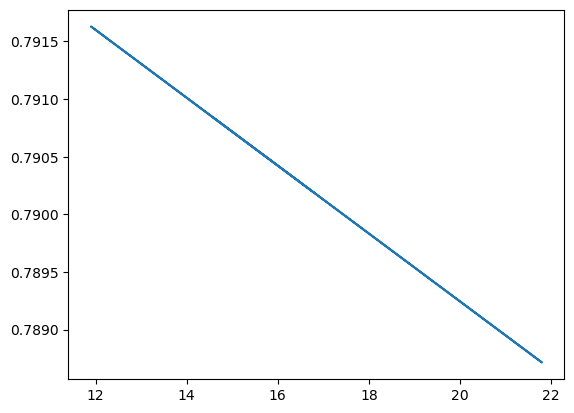

In [24]:
plt.plot(temp_test,predicted_pressure)
plt.xlabel = 'temperature'
plt.ylabel = 'pressure_1'

# Linear regression - now with electricity_1 and pressure_1

In [194]:
model_electricity_pressure = LinearRegression()

In [195]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(df['electricity_1']).reshape(-1,1)
pressure_2_array = np.array(df['pressure_1']).reshape(-1,1)

In [196]:
# splits the arrays into train and test sets
electricity_train, electricity_test, pressure_train, pressure_test = train_test_split(electricity_1_array, pressure_2_array,random_state=104, test_size=0.25, shuffle=True)

In [197]:
# trains the model
model_electricity_pressure.fit(electricity_train, pressure_train)

LinearRegression()

In [198]:
# uses the model to predict pressure_1
y_pred_pressure = model_electricity_pressure.predict(electricity_test)

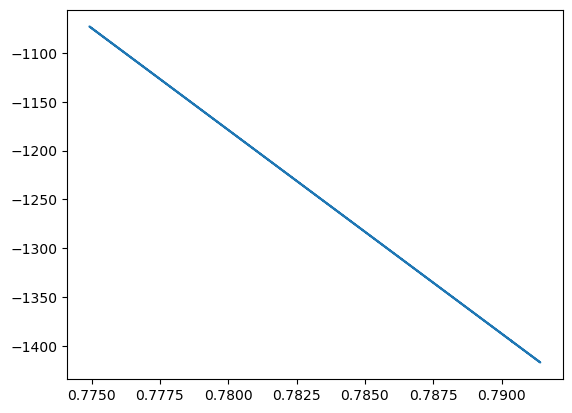

In [193]:
plt.plot(y_pred_pressure, electricity_test)

# Logistic Regression with pressure_1 and is_maintenance

In [199]:
model_log = LogisticRegression()

In [204]:
# creates numpy arrays using the columns in our dataframe
maintenance_array = np.array(df['is_maintenance']).reshape(-1,1)
time_array = np.array(df['time']).reshape(-1,1)
pressure_array = np.array(df['pressure_1']).reshape(-1,1)

In [205]:
# splits them into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pressure_array,maintenance_array,random_state=104,test_size=0.25,shuffle=True) 

In [206]:
# trains the model
model_log.fit(X_train, y_train)

/Users/annikaseo-yeonkim/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [207]:
# uses that to predict is_maintenance
y_pred_log = model_log.predict(X_test)

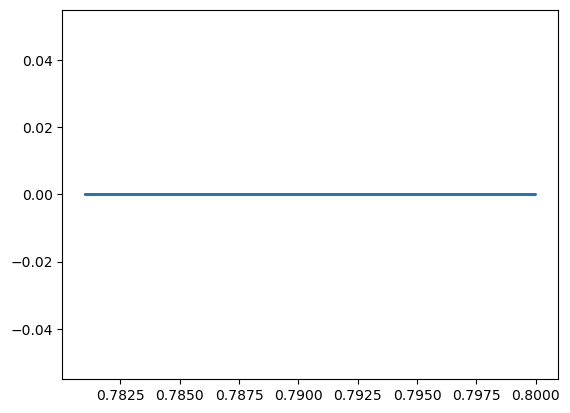

In [31]:
plt.plot(X_test, y_pred_log)

# Autoregression using lag plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

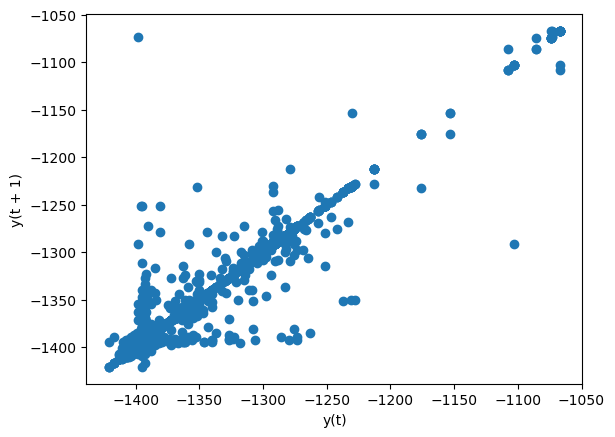

In [44]:
pd.plotting.lag_plot(df['electricity_1'],lag=1)

# Autocorrelation plots 

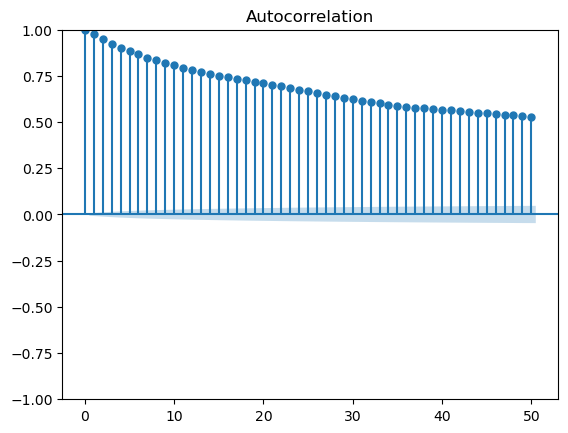

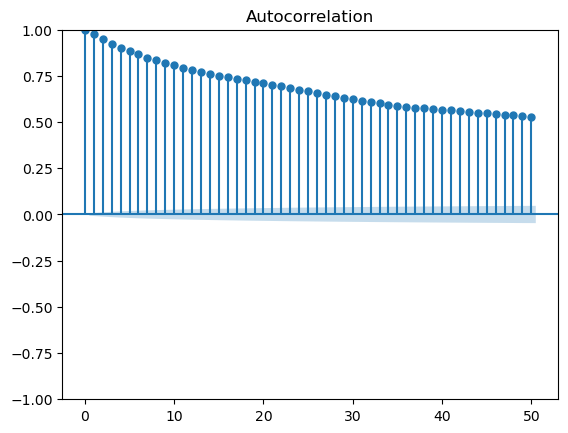

In [45]:
plot_acf(df['electricity_1'])

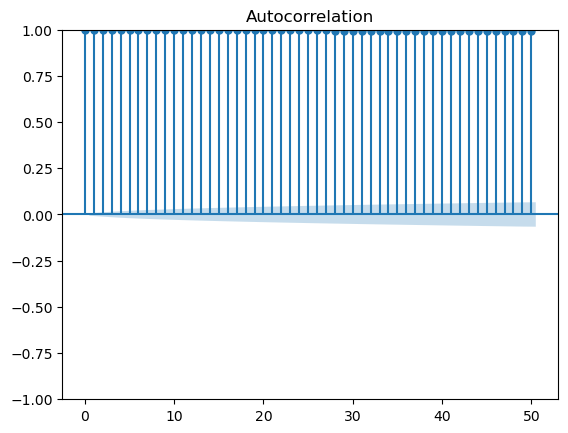

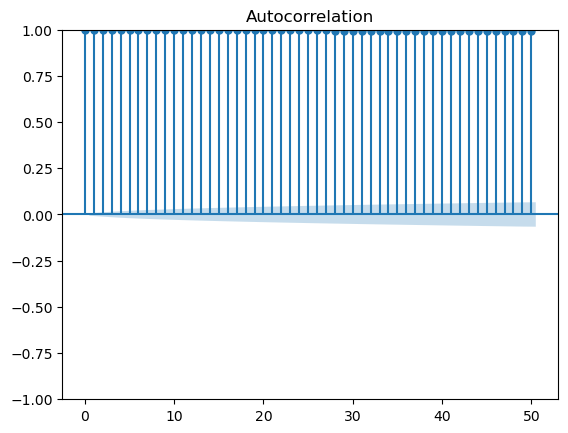

In [47]:
# log transformation - does nothing
log_pressure = np.log(df['pressure_1'])
plot_acf(log_pressure)

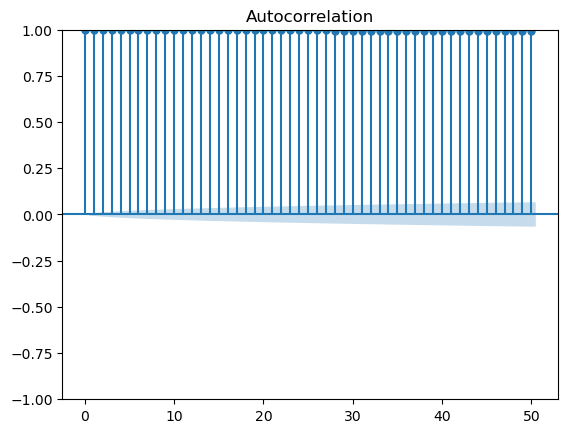

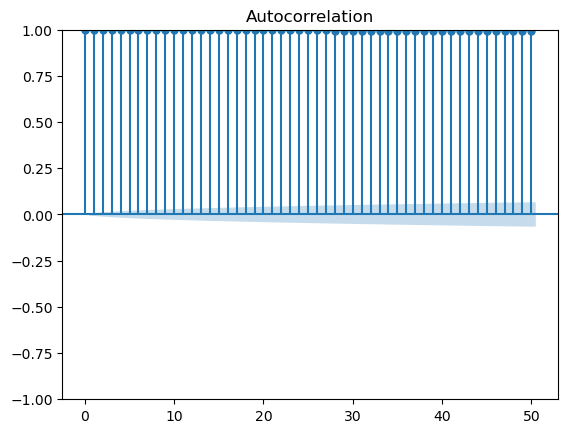

In [ ]:
plot_acf(df['pressure_1'])

# Rolling Average Plots

# #1. Electricity_1

In [54]:
rolling_average = df.electricity_1.rolling(1000).mean() # window = 1000

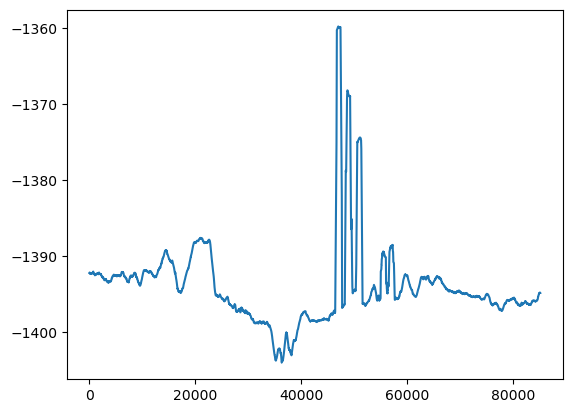

In [53]:
plt.plot(rolling_average)

In [55]:
rolling_average_2 = df.electricity_1.rolling(10000).mean() # window = 10000

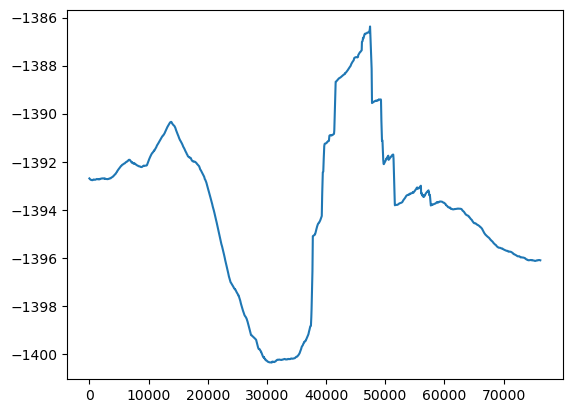

In [56]:
plt.plot(rolling_average_2)

<b> #2. pressure_1 </b>

In [57]:
rolling_average_pressure = df.pressure_1.rolling(1000).mean()

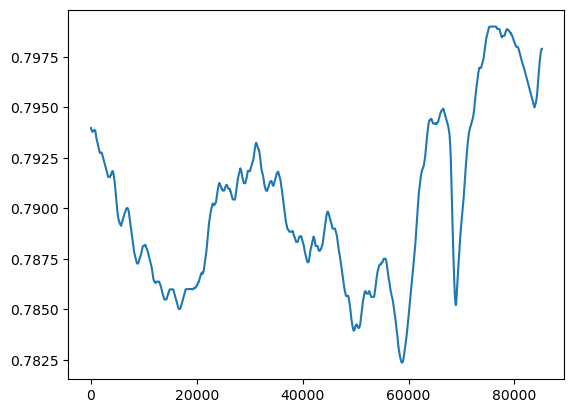

In [58]:
plt.plot(rolling_average_pressure)

In [59]:
rolling_average_pressure_1 = df.pressure_1.rolling(10000).mean()

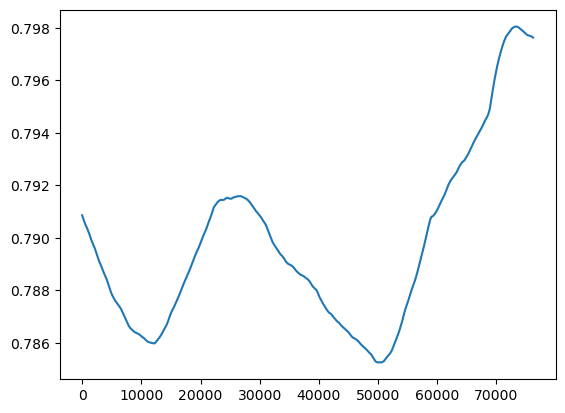

In [60]:
plt.plot(rolling_average_pressure_1)

In [ ]:
rolling_average_electricity_2 = df.electricity_2.rolling(1000).mean()

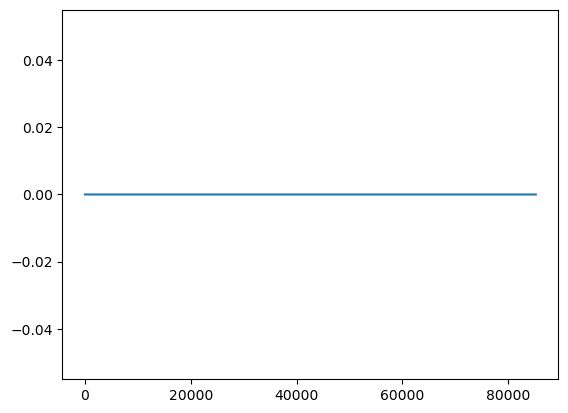

In [ ]:
plt.plot(rolling_average_electricity_2)

# 대표값 찾기 

# consolidating the dataset 

In [65]:
df.groupby('time').head()

,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86187,1,20240422,0,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86186,1,20240422,1,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86185,1,20240422,2,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86184,1,20240422,3,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
86183,1,20240422,4,0,-1399.0,0.0,0,0,1,0,...,0,0.797,2.122,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1,20240422,235955,0,-1392.0,0.0,0,0,1,0,...,0,0.795,2.135,0,0,0,0,0,0,0
3,1,20240422,235956,0,-1392.0,0.0,0,0,1,0,...,0,0.795,2.135,0,0,0,0,0,0,0
2,1,20240422,235957,0,-1392.0,0.0,0,0,1,0,...,0,0.795,2.135,0,0,0,0,0,0,0
1,1,20240422,235958,0,-1392.0,0.0,0,0,1,0,...,0,0.795,2.135,0,0,0,0,0,0,0


In [101]:
consolidated_df = pd.DataFrame()
electricity_average = df['electricity_1'].dropna().rolling(59).mean()
consolidated_df['electricity_1'] = electricity_average

In [103]:
consolidated_df['electricity_1'].isnull().sum()

58

In [148]:
df_clean = df.copy()
df_clean.head()

,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime,Hour
86187,1,20240422,0,0,-1399.0,0.0,0,0,1,0,...,0.797,2.122,0,0,0,0,0,0,0,0
86186,1,20240422,1,0,-1399.0,0.0,0,0,1,0,...,0.797,2.122,0,0,0,0,0,0,0,0
86185,1,20240422,2,0,-1399.0,0.0,0,0,1,0,...,0.797,2.122,0,0,0,0,0,0,0,0
86184,1,20240422,3,0,-1399.0,0.0,0,0,1,0,...,0.797,2.122,0,0,0,0,0,0,0,0
86183,1,20240422,4,0,-1399.0,0.0,0,0,1,0,...,0.797,2.122,0,0,0,0,0,0,0,0


# process_dataframe 

In [208]:
def process_dataframe(df, aggregation):
    # Extract hour from 'Time' column (assuming 'Time' is in seconds since midnight)
    df['Hour'] = df['time'] // 10000
    
    # Group by 'Hour' and aggregate the data
    if aggregation == 'mean':
        result_df = df.groupby('Hour').mean().reset_index()
    elif aggregation == 'median':
        result_df = df.groupby('Hour').median().reset_index()
    elif aggregation == 'mode':
        # Mode can return multiple values, we need the first one
        result_df = df.groupby('Hour').agg(lambda x: x.mode().iloc[0]).reset_index()
    elif aggregation == 'max': 
        result_df = df.groupby('Hour').max().reset_index()
    else:
        raise ValueError("Aggregation method not supported. Use 'mean', 'median', or 'mode'.")
    
    # Drop the 'Time' column as it's not needed in the result
    result_df = result_df.drop(columns=['time'])
    
    return result_df

result_df = process_dataframe(df,'max')

# Visualization

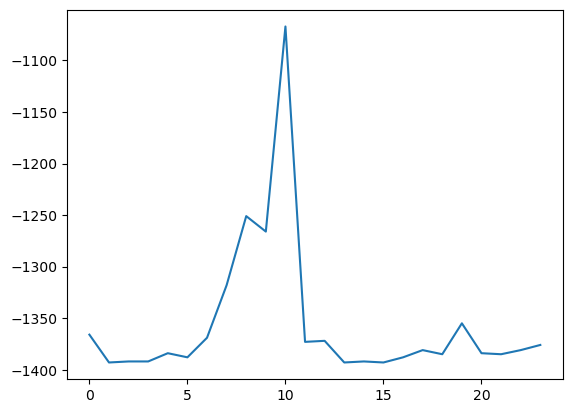

In [157]:
plt.plot(result_df['electricity_1'])

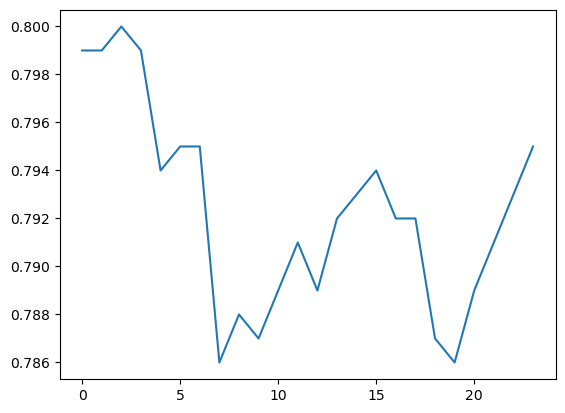

In [162]:
plt.plot(result_df['pressure_1'])

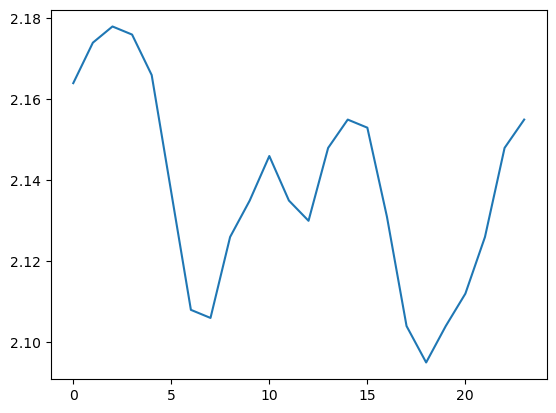

In [165]:
plt.plot(result_df['pressure_2'])

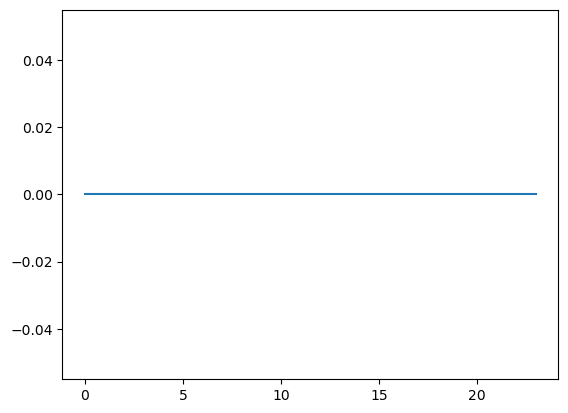

In [168]:
plt.plot(result_df['electricity_2'])

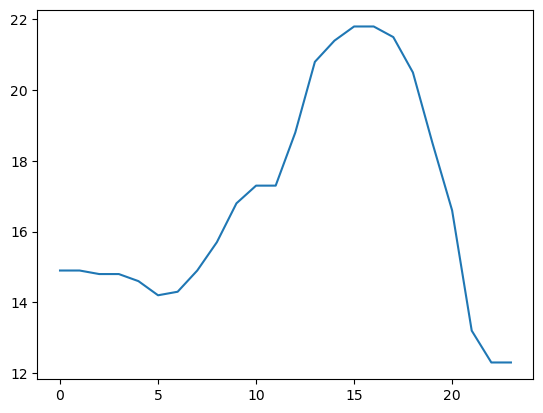

In [169]:
plt.plot(result_df['outside_temperature'])

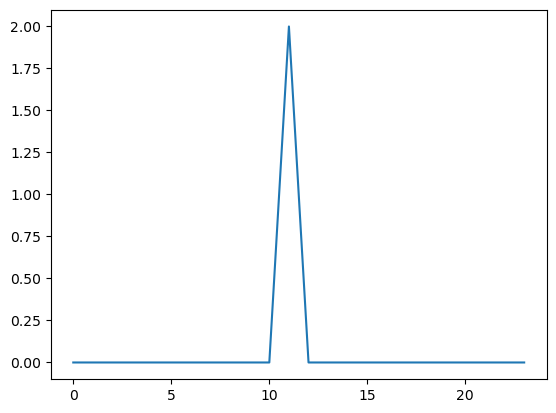

In [170]:
plt.plot(result_df['is_maintenance'])

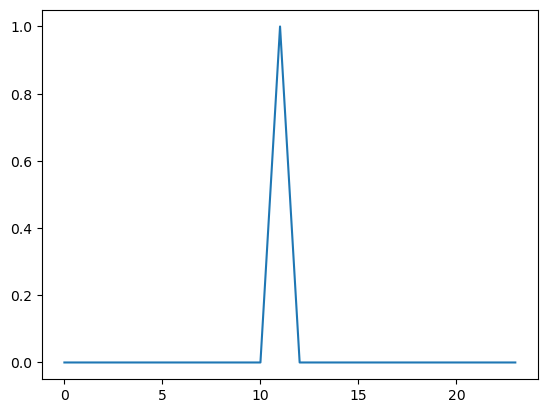

In [172]:
plt.plot(result_df['door_open'])

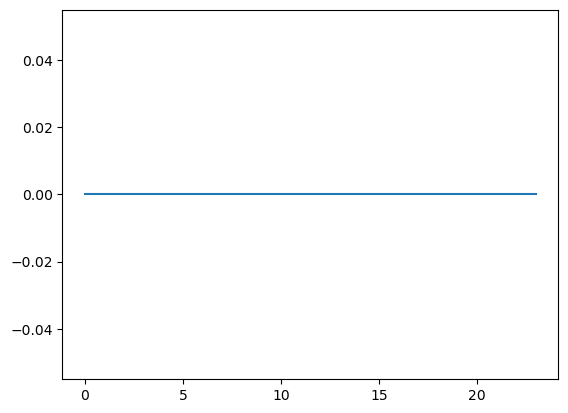

In [178]:
plt.plot(result_df['status_electricity_2'])

# Linear Regression using our new dataframe

In [211]:
model_new = LinearRegression()

In [218]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(result_df['electricity_1']).reshape(-1,1)
maintenance_array_new = np.array(result_df['is_maintenance']).reshape(-1,1)

In [219]:
# splits the arrays into train and test sets
electricity_train, electricity_test, maintenance_train, maintenance_test = train_test_split(electricity_1_array, maintenance_array_new,random_state=104, test_size=0.25, shuffle=True)

In [221]:
# trains the model
model_electricity_pressure.fit(electricity_train, maintenance_train)

LinearRegression()

In [224]:
# uses the model to predict pressure_1
y_pred_maintenance = model_electricity_pressure.predict(electricity_test)

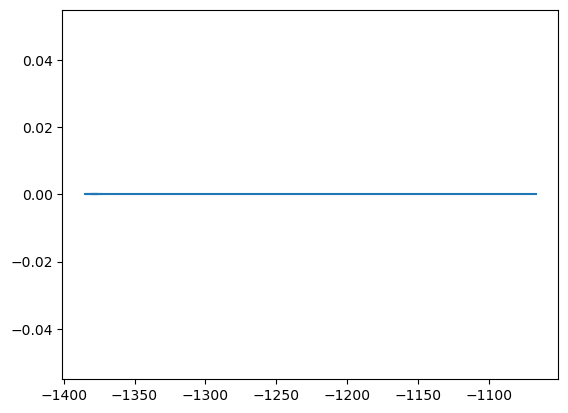

In [225]:
plt.plot(electricity_test, y_pred_maintenance)